# Data preparations

## Clean data

In [1]:
import pandas as pd

df = pd.read_csv('./data/dataset_2.tsv', delimiter='\t', encoding='utf-8')

df

,text,from,to,moment
0,Depuis La Chaize-le-vicomte à La Roche-sur-foron,La Chaize-le-vicomte,La Roche-sur-foron,NaN
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny,NaN
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau,mardi
3,Je suis actuellement à Villers-sur-mer et j’ai...,Villers-sur-mer,Ferrières-en-bray,NaN
4,Donne moi l'itinéraire pour aller à Fontenay-l...,Lizy-sur-ourcq,Fontenay-le-fleury,NaN
...,...,...,...,...
2858,"De Lyon, je souhaite me rendre à Chamonix pour...",Lyon,Chamonix,NaN
2859,"De Lille, je souhaite me rendre à Lillebonne p...",Lille,Lillebonne,NaN
2860,"De Strasbourg, je souhaite voyager en train ve...",Strasbourg,Colmar,NaN
2861,Pour rejoindre Monaco depuis Marseille en bate...,Marseille,Monaco,NaN


In [2]:
df.head()

,text,from,to,moment
0,Depuis La Chaize-le-vicomte à La Roche-sur-foron,La Chaize-le-vicomte,La Roche-sur-foron,NaN
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny,NaN
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau,mardi
3,Je suis actuellement à Villers-sur-mer et j’ai...,Villers-sur-mer,Ferrières-en-bray,NaN
4,Donne moi l'itinéraire pour aller à Fontenay-l...,Lizy-sur-ourcq,Fontenay-le-fleury,NaN


In [3]:
# remove moment column
df = df.drop('moment', axis=1)
df.head()

,text,from,to
0,Depuis La Chaize-le-vicomte à La Roche-sur-foron,La Chaize-le-vicomte,La Roche-sur-foron
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau
3,Je suis actuellement à Villers-sur-mer et j’ai...,Villers-sur-mer,Ferrières-en-bray
4,Donne moi l'itinéraire pour aller à Fontenay-l...,Lizy-sur-ourcq,Fontenay-le-fleury


In [4]:
# Select lines which contains brackets
df[df['text'].str.contains(r'\(.*\)', na=False)]

,text,from,to


In [5]:
df[df.isna().any(axis=1)]

,text,from,to
2000,Les chats noirs portent bonheur.,NaN,NaN
2001,Le chocolat est ma passion.,NaN,NaN
2002,Les étoiles scintillent dans le ciel nocturne.,NaN,NaN
2003,Les montagnes sont majestueuses en hiver.,NaN,NaN
2004,Les oiseaux chantent au lever du soleil.,NaN,NaN
...,...,...,...
2823,Je veux me rendre à Rochefort.,NaN,Rochefort
2824,Comment puis-je arriver à Saint-Malo ?,NaN,Saint-Malo
2825,J'aimerais aller à Thiers.,NaN,Thiers
2826,Je souhaite me rendre à Ussel.,NaN,Ussel


In [73]:
# Count lines where both 'from' and 'to' are NaN
both_nan_count = len(df[(df['from'].isna()) & (df['to'].isna())])

# Count lines where 'from' contains a value and 'to' is NaN
from_not_nan_count = len(df[(~df['from'].isna()) & (df['to'].isna())])

# Count lines where 'from' is NaN and 'to' contains a value
to_not_nan_count = len(df[(df['from'].isna()) & (~df['to'].isna())])

# Count lines where both 'from' and 'to' contain values
both_not_nan_count = len(df[(~df['from'].isna()) & (~df['to'].isna())])

print(f"Both 'from' and 'to' are NaN: {both_nan_count} lines")
print(f"'from' has a value and 'to' is NaN: {from_not_nan_count} lines")
print(f"'from' is NaN and 'to' has a value: {to_not_nan_count} lines")
print(f"Both 'from' and 'to' have values: {both_not_nan_count} lines")

Both 'from' and 'to' are NaN: 428 lines
'from' has a value and 'to' is NaN: 100 lines
'from' is NaN and 'to' has a value: 300 lines
Both 'from' and 'to' have values: 2035 lines


## Labelized Data

This problem is a NER problem. Our model's goal is to classify each word to be a city **FROM** or **TO**.

Our cities contains multiple word like "La Chaize-le-vicomte" we need o process them.
We can process them using IOB tagging system.

In our case, it will be:
-  **B**: beginning of the chunk
- **I**: inside of the chunk
- **FROM**: city to departure
- **TO**: city to arrive
- **O**: Other

In [6]:
import re

# Remove punctuations
def remove_punctuations(sentence):
    punctuation_chars = [",", ".", "?"]
    pattern = "[" + "".join([re.escape(char) for char in punctuation_chars]) + "]"
    cleaned_sentence = re.sub(pattern, "", sentence)
    return cleaned_sentence

# Apply the function to remove periods from the 'text' column
df['text'] = df['text'].apply(remove_punctuations)

In [7]:
# create labels sequence using IOB system (for multi word city names)
def create_IOB_label_sequence(sentence, city_from, city_to):
    words = sentence.split()  
    labels = []  
    # manage NaN
    city_from_words = city_from.split() if not pd.isna(city_from) else []
    city_to_words = city_to.split() if not pd.isna(city_to) else []

    index = 0  
    while index < len(words):
        if ' '.join(words[index:index + len(city_from_words)]) == city_from:
            labels.append('B-FROM')
            labels.extend(['I-FROM'] * (len(city_from_words) - 1))
            index += len(city_from_words)
        elif ' '.join(words[index:index + len(city_to_words)]) == city_to:
            labels.append('B-TO')
            labels.extend(['I-TO'] * (len(city_to_words) - 1))
            index += len(city_to_words)
        else:
            labels.append('O')
            index += 1

    return labels

df['IOB_labels'] = df.apply(lambda row: create_IOB_label_sequence(row['text'], row['from'], row['to']), axis=1)
df

,text,from,to,IOB_labels
0,Depuis La Chaize-le-vicomte à La Roche-sur-foron,La Chaize-le-vicomte,La Roche-sur-foron,"[O, B-FROM, I-FROM, O, B-TO, I-TO]"
1,Itiniréraire jusqu'a Giromagny depuis Quimper,Quimper,Giromagny,"[O, O, B-TO, O, B-FROM]"
2,Comment aller de Boigneville à Longjumeau mardi,Boigneville,Longjumeau,"[O, O, O, B-FROM, O, B-TO, O]"
3,Je suis actuellement à Villers-sur-mer et j’ai...,Villers-sur-mer,Ferrières-en-bray,"[O, O, O, O, B-FROM, O, O, O, O, B-TO]"
4,Donne moi l'itinéraire pour aller à Fontenay-l...,Lizy-sur-ourcq,Fontenay-le-fleury,"[O, O, O, O, O, O, B-TO, O, O, O, B-FROM]"
...,...,...,...,...
2858,De Lyon je souhaite me rendre à Chamonix pour ...,Lyon,Chamonix,"[O, B-FROM, O, O, O, O, O, B-TO, O, O, O, O, O..."
2859,De Lille je souhaite me rendre à Lillebonne po...,Lille,Lillebonne,"[O, B-FROM, O, O, O, O, O, B-TO, O, O, O, O, O..."
2860,De Strasbourg je souhaite voyager en train ver...,Strasbourg,Colmar,"[O, B-FROM, O, O, O, O, O, O, B-TO, O, O, O, O..."
2861,Pour rejoindre Monaco depuis Marseille en bate...,Marseille,Monaco,"[O, O, B-TO, O, B-FROM, O, O, O, O, O, O, O, O..."


In [8]:
df[df.isna().any(axis=1)]

,text,from,to,IOB_labels
2000,Les chats noirs portent bonheur,NaN,NaN,"[O, O, O, O, O]"
2001,Le chocolat est ma passion,NaN,NaN,"[O, O, O, O, O]"
2002,Les étoiles scintillent dans le ciel nocturne,NaN,NaN,"[O, O, O, O, O, O, O]"
2003,Les montagnes sont majestueuses en hiver,NaN,NaN,"[O, O, O, O, O, O]"
2004,Les oiseaux chantent au lever du soleil,NaN,NaN,"[O, O, O, O, O, O, O]"
...,...,...,...,...
2823,Je veux me rendre à Rochefort,NaN,Rochefort,"[O, O, O, O, O, B-TO]"
2824,Comment puis-je arriver à Saint-Malo,NaN,Saint-Malo,"[O, O, O, O, B-TO]"
2825,J'aimerais aller à Thiers,NaN,Thiers,"[O, O, O, B-TO]"
2826,Je souhaite me rendre à Ussel,NaN,Ussel,"[O, O, O, O, O, B-TO]"


## Split data

In [9]:
X = df['text'].values
y = df['IOB_labels'].values

X[:10], y[:10]

(array(['Depuis La Chaize-le-vicomte à La Roche-sur-foron',
        "Itiniréraire jusqu'a Giromagny depuis Quimper",
        'Comment aller de Boigneville à Longjumeau mardi',
        'Je suis actuellement à Villers-sur-mer et j’aimerais partir à Ferrières-en-bray',
        "Donne moi l'itinéraire pour aller à Fontenay-le-fleury en partant de Lizy-sur-ourcq",
        'Comment aller de Viviers-du-lac à Aytré',
        'Je pars de Caen pour aller à Villeneuve-la-comtesse',
        "le départ et l'arrivée de mon voyage sont Sathonay-camp et Quillan",
        'Quel trajet pour Éveux Grandvilliers',
        'train Wizernes Sillé-le-guillaume'], dtype=object),
 array([list(['O', 'B-FROM', 'I-FROM', 'O', 'B-TO', 'I-TO']),
        list(['O', 'O', 'B-TO', 'O', 'B-FROM']),
        list(['O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'O']),
        list(['O', 'O', 'O', 'O', 'B-FROM', 'O', 'O', 'O', 'O', 'B-TO']),
        list(['O', 'O', 'O', 'O', 'O', 'O', 'B-TO', 'O', 'O', 'O', 'B-FROM']),
        list([

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(array(['Les rires sont contagieux',
        'Ma provenance et ma destination sont Cinq-mars-la-pile et Le Meux',
        'Je veux me rendre à Yssingeaux',
        'Les balançoires sont amusantes au parc',
        'Je veux aller à Bertrichamps depuis Thuès-entre-valls'],
       dtype=object),
 array([list(['O', 'O', 'O', 'O']),
        list(['O', 'O', 'O', 'O', 'O', 'O', 'B-FROM', 'O', 'B-TO', 'I-TO']),
        list(['O', 'O', 'O', 'O', 'O', 'B-TO']),
        list(['O', 'O', 'O', 'O', 'O', 'O']),
        list(['O', 'O', 'O', 'O', 'B-TO', 'O', 'B-FROM'])], dtype=object))

In [71]:
len(X_train), len(y_test)

(2290, 573)

In [72]:
len(X)

2863

# Text vectorization (Tokenisation)



## Vectorizing X (Sentences)

In [59]:
# Combine all the text data into a single string
combined_text = ' '.join(df['text'])

# Tokenize the combined text into words (you can use a regex pattern)
words = re.findall(r'\w+', combined_text.lower())

# Create a set to store unique words
unique_words = set(words)

# Count the number of unique words
num_unique_words = len(unique_words)

print("Number of unique words:", num_unique_words)

Number of unique words: 3532


In [60]:
# Find the longest sentence by word count
longest_sentence = df['text'].explode().apply(lambda x: len(x.split())).idxmax()
longest_sentence_text = df['text'].explode()[longest_sentence]

len(longest_sentence_text.split())

36

In [61]:
from keras.layers import TextVectorization
import tensorflow as tf
import re
import string

max_vocab_length = 4000 # max number of words to have in our vocabulary 
max_length = 30 # max length our sequences will be

# Custom standardization function
def custom_standardization(input_text):
    # Remove punctuations, but preserve apostrophes
    return tf.strings.regex_replace(input_text, "[^a-zA-Z0-9À-ÖØ-öø-ÿ' ]", "")

text_vectorizer = TextVectorization(max_tokens=max_vocab_length, # max number of words to have in our vocabulary
                                    standardize=custom_standardization,
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_length
                                    )

# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [62]:
# Choose a random sentence from the training dataset and tokenize it
import random

random_sentence = random.choice(X_train)
print(f"Original text:\n {random_sentence} \
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Je partirais de Tassin-la-demi-lune pour aller à Avesnelles       

Vectorized version:


<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[   4,   41,    3,  830,    6,    5,    2, 2977,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int64)>

In [63]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5+2] # get most common words (with the 2 specials characters, O: padding token, UNK: unknown)
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 3045
5 most common words: ['', '[UNK]', 'à', 'de', 'Je', 'aller', 'pour']
5 least common words: ['Albert', 'AixlesBains', 'Aillysurnoye', 'Aiguesmortes', 'Acheres']


## Preparing Y (IOB Labels)

IOB labels should be converted also to numerical format.

In [64]:
import itertools

# flatten labels
y_flatten = list(itertools.chain.from_iterable(y))
y_flatten_tensor = tf.convert_to_tensor(y_flatten)
y_flatten_tensor

<tf.Tensor: shape=(21398,), dtype=string, numpy=array([b'O', b'B-FROM', b'I-FROM', ..., b'O', b'O', b'O'], dtype=object)>

In [65]:
from keras.layers import StringLookup

label_lookup = StringLookup(output_mode='int',
                            max_tokens=5,
                            num_oov_indices=0)

# Fit the layer on training labels
label_lookup.adapt(y_flatten_tensor)

# Transform labels to integers
label_lookup.get_vocabulary()

['O', 'B-TO', 'B-FROM', 'I-TO', 'I-FROM']

In [66]:
y_train_transformed = [label_lookup(labels).numpy() for labels in y_train]
y_test_transformed = [label_lookup(labels).numpy() for labels in y_test]

y_train_transformed[:5], y_test_transformed[:5]

([array([0, 0, 0, 0], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 2, 0, 1, 3], dtype=int64),
  array([0, 0, 0, 0, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 0, 0], dtype=int64),
  array([0, 0, 0, 0, 1, 0, 2], dtype=int64)],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 2, 0], dtype=int64),
  array([0, 0, 0, 0, 0, 2, 0, 0, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 2, 0, 1], dtype=int64),
  array([0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 1, 3, 0, 0, 0], dtype=int64)])

In [67]:
# pad my y to be equals at X padded size
from keras.preprocessing.sequence import pad_sequences

# Define a padding value that's different from any actual IOB tags
PADDING_LABEL = label_lookup.vocabulary_size()  # 'num_tags' is the number of IOB tags you have

y_train_padded = pad_sequences(y_train_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)
y_test_padded = pad_sequences(y_test_transformed, maxlen=max_length, padding='post', value=PADDING_LABEL)

y_train_padded[:5], y_test_padded[:5]

(array([[0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 2, 0, 1, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 1, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0, 0, 0, 0, 2, 0, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5],
        [0, 0, 0,

# Make a modelling checkpoint callback

In [68]:


import os
import logging

tf.get_logger().setLevel(logging.WARNING) # remove INFO log (model saved at...)

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        monitor="val_loss",
        verbose=0, # only output a limited amount of text
        save_best_only=True,
    )

# Model creation

# Model 2 LSTM

In [69]:
from tensorflow import keras
from keras import layers

max_vocab_length = text_vectorizer.vocabulary_size() + 1 # Max number of words in the vocabulary (+ OOV token)
max_length = max_length # Max length of each sequence
num_tags = label_lookup.vocabulary_size() + 1 # Number of unique IOB tags (including 'O' and PADDING_LABEL)

model = keras.Sequential([
    layers.Input((1,), dtype=tf.string), # raw input string
    text_vectorizer, # turn the input text into numbers
    layers.Embedding(input_dim=max_vocab_length + 1, output_dim=128, mask_zero=False), # tells the model to ignore padded 0 (enhance correct sentences but more computation) ( False for evaluate, True for production)
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(num_tags, activation="softmax")), # make a prediction for each word in the sequence.
], name="model_2")

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(X_train,
          y_train_padded,
          epochs=30,
          validation_data=(X_test, y_test_padded),
          verbose=1,
          callbacks=[create_model_checkpoint(model_name=model.name)])

Epoch 1/30
72/72 [==============================] - 5s 48ms/step - loss: 0.6520 - accuracy: 0.8226 - val_loss: 0.3597 - val_accuracy: 0.9354
Epoch 2/30
72/72 [==============================] - 3s 47ms/step - loss: 0.2417 - accuracy: 0.9417 - val_loss: 0.1635 - val_accuracy: 0.9446
Epoch 3/30
72/72 [==============================] - 3s 40ms/step - loss: 0.1117 - accuracy: 0.9662 - val_loss: 0.0871 - val_accuracy: 0.9745
Epoch 4/30
72/72 [==============================] - 3s 39ms/step - loss: 0.0602 - accuracy: 0.9846 - val_loss: 0.0576 - val_accuracy: 0.9827
Epoch 5/30
72/72 [==============================] - 3s 44ms/step - loss: 0.0390 - accuracy: 0.9902 - val_loss: 0.0432 - val_accuracy: 0.9873
Epoch 6/30
72/72 [==============================] - 4s 50ms/step - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0346 - val_accuracy: 0.9898
Epoch 7/30
72/72 [==============================] - 3s 45ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 8/30
72

In [53]:

from tensorflow import keras
from keras import layers

# loss , accuracy
model_2 = keras.models.load_model('model_experiments/model_2', custom_objects={'custom_standardization': custom_standardization})
model_2.evaluate(X_test, y_test_padded)

9/9 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 0.9970


[0.009609833359718323, 0.9969802498817444]

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, multilabel_confusion_matrix
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall, and f1 score for multi-label classification with sequences.
    """
    # Flatten both y_true and y_pred
    y_true_flat = np.concatenate(y_true)
    y_pred_flat = np.concatenate(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true_flat, y_pred_flat) * 100
    
    # Calculate multilabel confusion matrix
    mcm = multilabel_confusion_matrix(y_true_flat, y_pred_flat)

    # Calculate weighted precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_flat, average="weighted")

    model_results = {"accuracy": accuracy,
                     "precision": precision,
                     "recall": recall,
                     "f1": f1, 
                     "mcm": mcm}
    
    return model_results



# def map_labels_to_names(labels):
#     return [class_names[label] for label in labels]

def plot_multilabel_confusion_matrix(mcm):
    """
    Display the confusion matrix for each label
    """
    class_names = label_lookup.get_vocabulary() + ["PAD"]
    num_labels = len(class_names)

    # Determine the number of rows and columns for subplots
    num_rows = int(num_labels / 3) + 1  # You can adjust the number of columns as needed
    num_cols = 3

    # Create a single figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_labels:
            label_name = class_names[i]
            confusion_matrix = mcm[i]

            sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
            ax.set_title(f"Confusion Matrix for {label_name}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        else:
            ax.axis("off")  # Hide any empty subplots

    plt.tight_layout()
    plt.show()

In [55]:
# def mask_and_decode_predictions(X, y_padded) -> list:
#     """
#     Masks padding and decodes model predictions for a sequence-to-sequence task.
#     """
#     y_labels_masked = []

#     # mask padding and decode prediction
#     for i, y_padded in enumerate(y_padded):
#         actual_length = len(X[i].split())  # Length of the actual sentence
#         y_label_masked = tf.argmax(y_padded, axis=-1).numpy()[:actual_length]  # Consider only actual length
#         y_labels_masked.append(y_label_masked)
        
#     return y_labels_masked

9/9 [==============================] - 0s 7ms/step
accuracy: 99.69802555168408
precision: 0.9969981989468708
recall: 0.9969802555168409
f1: 0.9969840385610287
mcm: [[[6937    5]
  [  16 1652]]

 [[8360    7]
  [   6  237]]

 [[8384    7]
  [   4  215]]

 [[8593    0]
  [   0   17]]

 [[8593    1]
  [   0   16]]

 [[2157    6]
  [   0 6447]]]


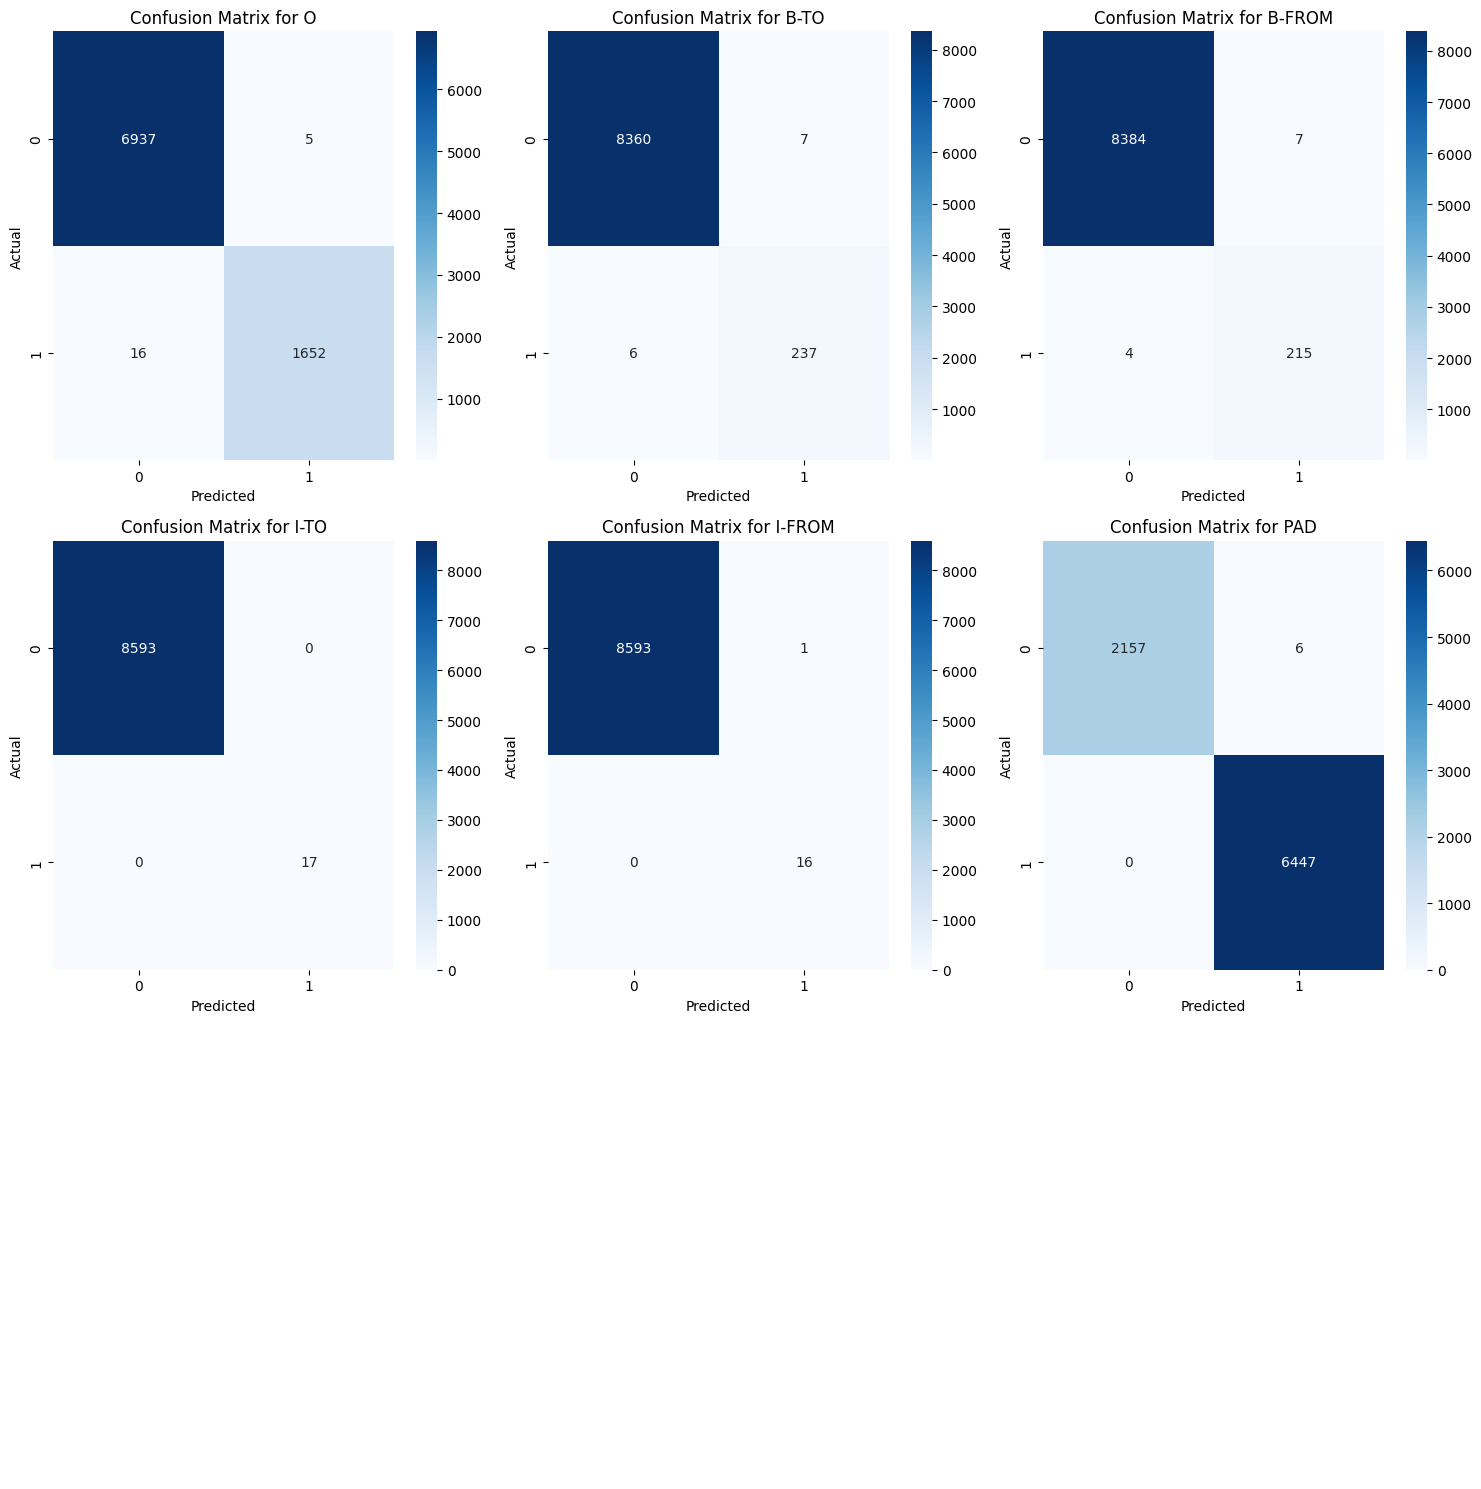

In [56]:
import numpy as np

y_pred = model_2.predict(X_test)
model_results = calculate_results(y_test_padded, np.argmax(y_pred, axis=-1))

# Print all keys except 'mcm'
for key, value in model_results.items():
        print(f"{key}: {value}")
        
plot_multilabel_confusion_matrix(model_results['mcm'])



For "B-TO":
    True Positives (TP): 453 (correctly identified arrival cities at the beginning of a chunk).
    False Negatives (FN): 18 (arrival cities at the beginning of a chunk that were missed).
    False Positives (FP): 27 (false alarms where the model incorrectly identified a city at the beginning of a chunk).
    True Negatives (TN): Not applicable in this context.

For "B-FROM":
    True Positives (TP): 406 (correctly identified departure cities at the beginning of a chunk).
    False Negatives (FN): 22 (departure cities at the beginning of a chunk that were missed).
    False Positives (FP): 19 (false alarms where the model incorrectly identified a city at the beginning of a chunk).
    True Negatives (TN): Not applicable in this context.

    

In [131]:
def make_prediction(model, sentences):
    decoded_predictions = []

    # make predictions
    predictions = model.predict(sentences)

    # mask padding and decode prediction
    for i, prediction in enumerate(predictions):
        actual_length = len(sentences[i].split())  # Length of the actual sentence
        
        predicted_tags = tf.argmax(prediction, axis=-1).numpy()[:actual_length]  # Consider only actual length
        print(actual_length)
        print((predicted_tags))
        # Map predicted tags to their labels, ignoring padding
        decoded_predictions.append([label_lookup.get_vocabulary()[tag] for tag in predicted_tags])

    return decoded_predictions

In [57]:
# Scenario 1: Sentences with neither departure nor arrival.
sentences_1 = [
    "Je veux partir nulle part",
    "OK",
    "Je veux une salade",
    "Il va skier a la station de ski",
    "Paul nous vends des chips",
]

# Scenario 2: Sentences with only a departure city.
sentences_2 = [
    "Comment part-on de Lyon",
    "Marseille",
    "Comment je vais de Paris a",
    "Je veux partir de Grenoble",
    "Depuis Tours",
]

# Scenario 3: Sentences with only an arrival city.

# Scenario 4: Sentences with both a departure and an arrival city.
sentences_4 = [
    "Comment peut-on se rendre de Paris à Marseille rapidement",
    "Quel est le moyen de transport le plus pratique pour aller de Lyon à Bordeaux",
    "Y a-t-il un train direct de Nice à Strasbourg",
    "Pouvez-vous me dire comment rejoindre Toulouse depuis Lille",
    "Quelle est la meilleure manière de voyager de Nantes à Montpellier",
]


predictions = make_prediction(model_2, sentences_4)


for sentence, prediction in zip(sentences_4, predictions):
    print(sentence)
    print(prediction)

NameError: name 'make_prediction' is not defined

In [133]:
text_vectorizer(['Comment peut-on se rendre de Paris à Marseille rapidement'])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[ 19,   1,  95,  16,   3, 145,   2, 116,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int64)>